# Workflow example to generate timelapses

This example illustrates how to use an `EOWorkflow` to create time-lapses

### Create cloudless timelapse

Imports from `sentinelhub` and `eolearn` to set up workflow that creates a timelapse

In [1]:
from sentinelhub import BBox, CRS, MimeType, CustomUrlParam
import numpy as np
import datetime

In [2]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.core import EOPatch, FeatureType, EOWorkflow
from eolearn.features import SimpleFilterTask
from eolearn.io import S2L1CWCSInput

Set up BBox of ROI and time interval

In [3]:
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2017-01-01', '2018-05-01')

This predicate function filters the images with a cloud coverage larger than a threshold to ensure images do not contain cloudy pixels

In [4]:
class MaxCCPredicate:
    def __init__(self, maxcc):
        self.maxcc = maxcc

    def __call__(self, img_cm):
        w, h, _ = img_cm.shape
        cc = np.sum(img_cm) / (w * h)
        return cc <= self.maxcc

Tasks of the workflow:
 * download S2 images (all 13 bands)
 * run `s2cloudless` to compute cloud masks
 * filter out images with cloud coverage larger than a given threshold (e.g. 0.05)

In [5]:
wcs_task = S2L1CWCSInput(layer='BANDS-S2-L1C', 
                         resx='20m',
                         resy='20m',
                         time_difference=datetime.timedelta(hours=2))

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
add_clm = AddCloudMaskTask(cloud_classifier, 
                           'BANDS-S2-L1C', 
                           cm_size_y='60m',
                           cm_size_x='60m', 
                           cmask_feature='clm', 
                           cprobs_feature='clp')

filter_task = SimpleFilterTask((FeatureType.MASK, 'clm'), MaxCCPredicate(maxcc=0.05))

c:\users\tslijepcevic\miniconda3\envs\eolearn\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Finished loading model, total used 170 iterations


Build and execute timelapse as chain of transforms

In [6]:
timelapse = EOWorkflow.make_linear_workflow(wcs_task, add_clm, filter_task)
result = timelapse.execute({wcs_task: {'bbox': roi_bbox, 'time_interval': time_interval}})

c:\users\tslijepcevic\miniconda3\envs\eolearn\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Get result as an eopatch

In [7]:
eopatch_clean, = [result[key] for key in result.keys()]

#### Help function to create GIFs

In [8]:
import imageio, os
def make_gif(eopatch, project_dir, filename, fps):
    """
    Generates a GIF animation from an EOPatch.
    """
    with imageio.get_writer(os.path.join(project_dir, filename), mode='I', fps=fps) as writer:
            for image in eopatch:
                writer.append_data(np.array(image[..., [3, 2, 1]], dtype=np.uint8))

Write clean EOPatch to GIF

In [9]:
make_gif(eopatch=eopatch_clean.data['BANDS-S2-L1C']*2.5*255, project_dir='.', filename='eopatch_clean.gif', fps=3)

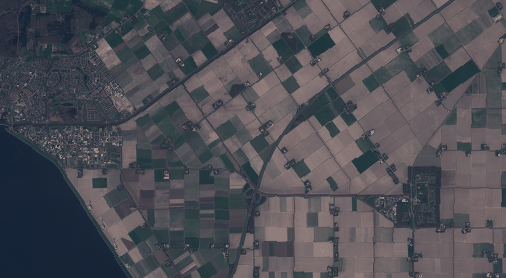

In [10]:
from IPython.display import Image

Image(filename="eopatch_clean.gif")